In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, Sequential
from keras.optimizers import RMSprop

In [10]:
fname = os.path.join("jena_climate_2009_2016/jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [12]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)

(420451, 14)


Text(0.5, 1.0, 'Whole temperature series')

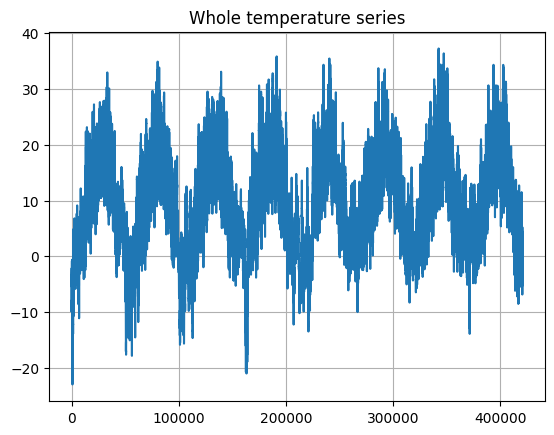

In [26]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.grid()
plt.title('Whole temperature series')

720.0


Text(0.5, 1.0, 'First 5 days')

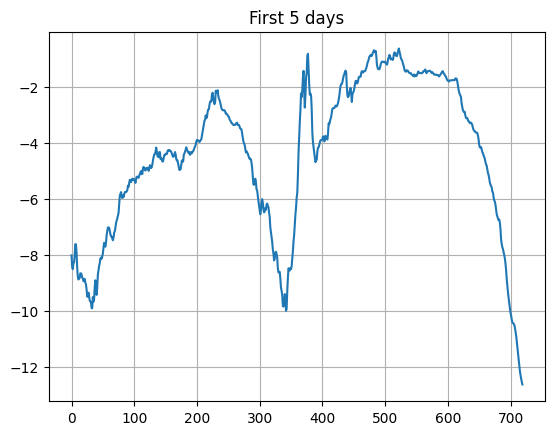

In [27]:
print(5*24*60/10)
plt.plot(range(720), temp[:720])
plt.grid()
plt.title('First 5 days')

In [35]:
num_train_samples = 200000


In [36]:
mean = float_data[:num_train_samples].mean(axis=0)
float_data -= mean

std = float_data[:num_train_samples].std(axis=0)
float_data /= std
# print(len(float_data))

In [37]:
# generator function used to feed the training, validation and test data

def generator(data, lookback, delay, min_index, max_index,
                shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [38]:
#TODO Define lookback, step, delay and batch size variable
lookback = 720
delay = 144
step = 6
batch_size = 128

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=200000,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)

#TODO: Set a validation generator similar to train generator. Use next 100000 samples (max index from 200,000 to 300,000). Do not shuftle the data:

val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=200000,
                        max_index=300000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

#TODO: Set a validation generator similar to a train generator. Use further next 100000 samples (max index from 300,000 onwards). Do not shuffle the data:

test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=300000,
                        max_index=400000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

In [41]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback)//batch_size 

#TODO: Train the network for about 20 epochs
history = model.fit(train_gen, batch_size=batch_size, epochs=20, steps_per_epoch=100, validation_steps=val_steps, validation_data=val_gen)

#TODO: Plot the results

Epoch 1/20
100/100 [==============================] - 12s 114ms/step - loss: 1.2710 - val_loss: 1.2352
Epoch 2/20
100/100 [==============================] - 6s 61ms/step - loss: 0.8971 - val_loss: 0.8171
Epoch 3/20
100/100 [==============================] - 6s 62ms/step - loss: 0.7287 - val_loss: 0.7233
Epoch 4/20
100/100 [==============================] - 6s 62ms/step - loss: 0.5989 - val_loss: 0.4975
Epoch 5/20
100/100 [==============================] - 6s 60ms/step - loss: 0.5007 - val_loss: 0.4564
Epoch 6/20
100/100 [==============================] - 6s 61ms/step - loss: 0.4301 - val_loss: 0.3641
Epoch 7/20
100/100 [==============================] - 5s 55ms/step - loss: 0.3809 - val_loss: 0.3763
Epoch 8/20
100/100 [==============================] - 6s 56ms/step - loss: 0.3501 - val_loss: 0.4143
Epoch 9/20
100/100 [==============================] - 5s 55ms/step - loss: 0.3288 - val_loss: 0.2988
Epoch 10/20
100/100 [==============================] - 6s 58ms/step - loss: 0.3185 - val_

In [44]:
model2 = Sequential()
model2.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model2.add(layers.Dense(1))
model2.compile(optimizer=RMSprop(), loss='mae')
history2 = model2.fit(train_gen, batch_size=batch_size, epochs=20, steps_per_epoch=100, validation_steps=val_steps, validation_data=val_gen)


Epoch 1/20
100/100 [==============================] - 18s 165ms/step - loss: 0.3120 - val_loss: 0.2853
Epoch 2/20
100/100 [==============================] - 15s 148ms/step - loss: 0.3026 - val_loss: 0.2796
Epoch 3/20
100/100 [==============================] - 16s 158ms/step - loss: 0.3004 - val_loss: 0.2792
Epoch 4/20
100/100 [==============================] - 17s 166ms/step - loss: 0.2917 - val_loss: 0.2709
Epoch 5/20
100/100 [==============================] - 15s 147ms/step - loss: 0.2910 - val_loss: 0.2720
Epoch 6/20
100/100 [==============================] - 16s 162ms/step - loss: 0.2901 - val_loss: 0.2697
Epoch 7/20
100/100 [==============================] - 16s 158ms/step - loss: 0.2868 - val_loss: 0.2662
Epoch 8/20
100/100 [==============================] - 15s 155ms/step - loss: 0.2877 - val_loss: 0.2685
Epoch 9/20
100/100 [==============================] - 14s 140ms/step - loss: 0.2864 - val_loss: 0.2677
Epoch 10/20
100/100 [==============================] - 14s 144ms/step - l

In [54]:
model3 = Sequential()
model3.add(layers.GRU(32, input_shape=(None, float_data.shape[-1]), return_sequences=True))
model3.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(None, float_data.shape[-1])))
model3.add(layers.Dense(1))
model3.compile(optimizer=RMSprop(), loss='mae')
history3 = model3.fit(train_gen, batch_size=batch_size, epochs=20, steps_per_epoch=100, validation_steps=val_steps, validation_data=val_gen)


Epoch 1/20
100/100 [==============================] - 34s 293ms/step - loss: 0.3669 - val_loss: 0.2953
Epoch 2/20
100/100 [==============================] - 28s 286ms/step - loss: 0.3230 - val_loss: 0.2843
Epoch 3/20
100/100 [==============================] - 28s 282ms/step - loss: 0.3132 - val_loss: 0.2810
Epoch 4/20
100/100 [==============================] - 28s 280ms/step - loss: 0.3054 - val_loss: 0.2773
Epoch 5/20
100/100 [==============================] - 28s 281ms/step - loss: 0.3066 - val_loss: 0.2793
Epoch 6/20
100/100 [==============================] - 28s 278ms/step - loss: 0.3024 - val_loss: 0.2874
Epoch 7/20
100/100 [==============================] - 28s 280ms/step - loss: 0.3004 - val_loss: 0.2725
Epoch 8/20
100/100 [==============================] - 27s 277ms/step - loss: 0.2988 - val_loss: 0.2990
Epoch 9/20
100/100 [==============================] - 28s 278ms/step - loss: 0.2968 - val_loss: 0.2701
Epoch 10/20
100/100 [==============================] - 30s 300ms/step - l

In [50]:
model4 = Sequential()
model4.add(layers.Conv1D(32, 5, activation='relu',
        input_shape=(None, float_data.shape[-1])))
model4.add(layers.MaxPooling1D(3))
model4.add(layers.Conv1D(32, 5, activation='relu'))
model4.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model4.add(layers.Dense(1))
model4.compile(optimizer=RMSprop(), loss='mae')
history4 = model4.fit(train_gen, batch_size=batch_size, epochs=20, steps_per_epoch=100, validation_steps=val_steps, validation_data=val_gen)


Epoch 1/20
100/100 [==============================] - 14s 107ms/step - loss: 0.3796 - val_loss: 0.3353
Epoch 2/20
100/100 [==============================] - 9s 92ms/step - loss: 0.3516 - val_loss: 0.3248
Epoch 3/20
100/100 [==============================] - 9s 89ms/step - loss: 0.3306 - val_loss: 0.2997
Epoch 4/20
100/100 [==============================] - 9s 95ms/step - loss: 0.3239 - val_loss: 0.2956
Epoch 5/20
100/100 [==============================] - 10s 99ms/step - loss: 0.3227 - val_loss: 0.3093
Epoch 6/20
100/100 [==============================] - 10s 99ms/step - loss: 0.3205 - val_loss: 0.3072
Epoch 7/20
100/100 [==============================] - 9s 94ms/step - loss: 0.3111 - val_loss: 0.3121
Epoch 8/20
100/100 [==============================] - 10s 98ms/step - loss: 0.3083 - val_loss: 0.3081
Epoch 9/20
100/100 [==============================] - 10s 96ms/step - loss: 0.3087 - val_loss: 0.2963
Epoch 10/20
100/100 [==============================] - 10s 96ms/step - loss: 0.3023 -

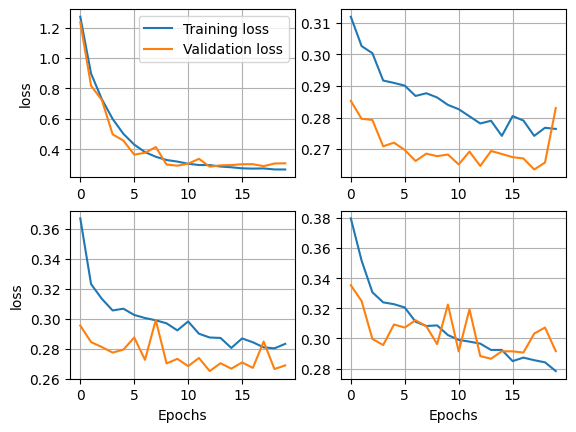

In [57]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(history.history['loss'], label= 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
# plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.plot(history2.history['loss'], label= 'Training loss')
plt.plot(history2.history['val_loss'], label = 'Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('loss')
plt.grid()

plt.subplot(2,2,3)
plt.plot(history3.history['loss'], label= 'Training loss')
plt.plot(history3.history['val_loss'], label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()

plt.subplot(2,2,4)
plt.plot(history4.history['loss'], label= 'Training loss')
plt.plot(history4.history['val_loss'], label = 'Validation loss')
plt.xlabel('Epochs')
# plt.ylabel('loss')
plt.grid()

plt.show()